## Q* Learning 
In this notebook, we'll implement an agent that plays FrozenLake.
The goal of this game is <b>to go from the starting state (S) to the goal state (G)</b> by walking only on frozen tiles (F) and avoid holes (H).However, the ice is slippery, <b>so you won't always move in the direction you intend (stochastic environment)</b>

We use 3 libraries:
- `Numpy` for our Qtable
- `Gymnasium` for our FrozenLake Environment. Read the documentation [here](https://gymnasium.farama.org/).
- `Random` to generate random numbers

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import random
from typing import NamedTuple

### Step 1: Create the environment
- Here we'll create the FrozenLake environment. 
- OpenAI Gym is a library <b> composed of many environments that we can use to train our agents.</b>
- In our case we choose to use Frozen Lake.
- Note that S is the subject, F is frozen, H is the hole, and G the goal.

In [ ]:
class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    max_steps: int
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    max_epsilon: float  # Exploration probability at start
    min_epsilon: float  # Minimum exploration probability
    map_size: int  # Number of tiles of one side of the squared environment
    seed: int  # Define a seed so that we get reproducible results
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    proba_frozen: float  # Probability that a tile is frozen
    decay_rate: float


params = Params(
    total_episodes=4000,
    learning_rate=0.8,
    max_steps=99,
    gamma=0.95,
    epsilon=1,
    max_epsilon=1.0,
    min_epsilon=0.01,
    map_size=4,
    seed=123,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    decay_rate=0.001,
)
print(params)

# #Test with different params
# epsilon = 0.5
# map = 3
# episode_max = 10000

# params = Params(
#     total_episodes=episode_max,
#     learning_rate=0.8,
#     max_steps=99,
#     gamma=0.95,
#     epsilon=epsilon,
#     max_epsilon = epsilon,
#     min_epsilon = 0.01,
#     map_size=map,
#     seed=123,
#     is_slippery=True,
#     n_runs=20,
#     action_size=None,
#     state_size=None,
#     proba_frozen=0.9,
#     decay_rate=0.001
# )

# Set the seed
rng = np.random.default_rng(params.seed)

Params(total_episodes=4000, learning_rate=0.8, max_steps=99, gamma=0.95, epsilon=1, max_epsilon=1.0, min_epsilon=0.01, map_size=6, seed=123, is_slippery=False, n_runs=20, action_size=None, state_size=None, proba_frozen=0.9, decay_rate=0.001)


In [225]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="ansi",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)

### Step 2: Create the Q-table and initialize it
- Now, we'll create our Q-table, to know how much rows (states) and columns (actions) we need, we need to calculate the action_size and the state_size
- OpenAI Gym provides us a way to do that: `env.action_space.n` and `env.observation_space.n`

In [226]:
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)

print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")

Action size: 4
State size: 36


In [227]:
# Complete the code to create the qtable from the action_size and state_size
qtable = np.zeros((params.state_size, params.action_size))
print(qtable)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### Step 3: The Q learning algorithm
- Now we implement the Q learning algorithm:
<img src="qtable_algo.png" alt="Q algo"/>

In [ ]:
# Step 1 --> Q-values are already initialized.

rewards = [] # List of rewards
steps = [] # List of steps
e_progress = []

# Step 2 --> For life or until learning is stopped ...
for episode in range(params.total_episodes):
    # Reset the environment
    state = env.reset()[0]
    step = 0
    done = False
    total_rewards = 0
    
    for step in range(params.max_steps):
        # Step 3 --> Choose an action (a) in the current world state (s)
        ## First we randomize a number between 0 and 1 following a uniform distribution.
        exp_exp_tradeoff = random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > params.epsilon:
            action = np.argmax(qtable[state])

        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()

        # Step 4 --> Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, terminated, truncated, info = env.step(action)

        # Step 5 --> Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        action_prim = np.argmax(qtable[new_state,:])
        qtable[state, action] += params.learning_rate*(reward + params.gamma * qtable[new_state, action_prim] - qtable[state, action])
        
        total_rewards += reward
        
        # Our new state is state
        state = new_state
        
        # If done (if we're dead) : finish episode
        done = truncated or terminated
        if done: 
            break

    steps.append(step + 1)
    rewards.append(total_rewards)

    # Reduce epsilon 
    params = params._replace(epsilon=params.min_epsilon + (params.max_epsilon - params.min_epsilon)*np.exp(-params.decay_rate*episode))
    e_progress.append(params.epsilon)


print ("Score over time: " +  str(sum(rewards)/params.total_episodes))
print(qtable)

Score over time: 0.00025
[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.8 0. ]
 [0.  0.  0.  0. ]]


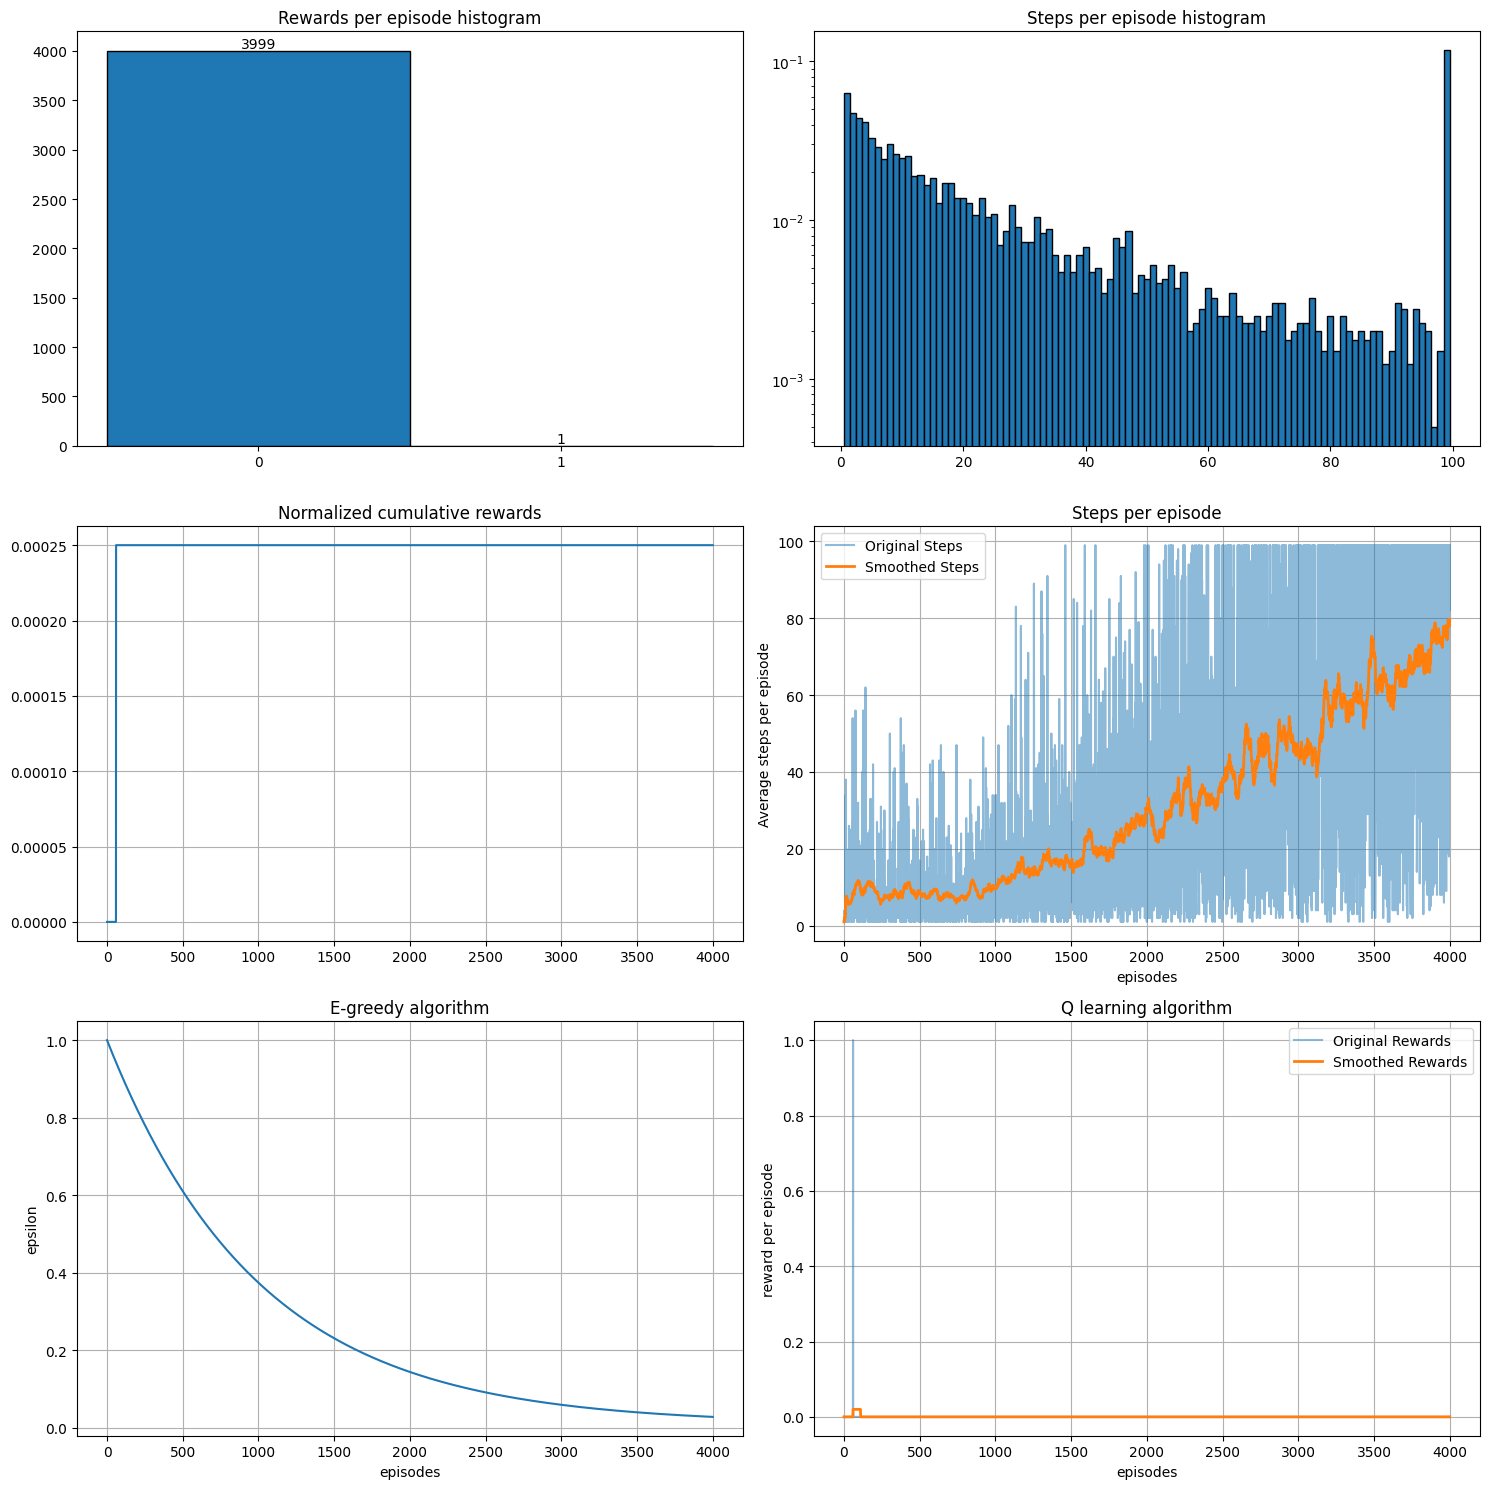

In [ ]:
# Display images
import matplotlib.pyplot as plt
def moving_average(data, window_size=50):
    """Compute moving average of a given list using specified window size."""
    cumsum = [0]
    for i, x in enumerate(data, 1):
        cumsum.append(cumsum[i-1] + x)
        if i >= window_size:
            moving_avg = (cumsum[i] - cumsum[i-window_size]) / window_size
            yield moving_avg
        else:
            yield cumsum[i] / i

fig, axarr = plt.subplots(3, 2, figsize=(15, 15)) 

# Histogram for rewards
n_rewards, bins_rewards, patches_rewards = axarr[0][0].hist(rewards, bins=[-0.5, 0.5, 1.5], edgecolor='black', align='mid', density=False)
axarr[0][0].set_title('Rewards per episode histogram')
axarr[0][0].set_xticks([0, 1])  # Set x-axis ticks for 0 and 1

# Annotate rewards histogram with counts
for count, patch in zip(n_rewards, patches_rewards):
    height = patch.get_height()
    axarr[0][0].text(patch.get_x() + patch.get_width() / 2, height + 0.1, int(count),
                     ha='center', va='bottom')

# Generate bin edges for steps histogram centered around integers
step_min = int(np.floor(min(steps)))
step_max = int(np.ceil(max(steps)))
bins_steps_centered = np.arange(step_min - 0.5, step_max + 1.5, 1)

# Histogram for steps
n_steps, _, patches_steps = axarr[0][1].hist(steps, bins=bins_steps_centered, edgecolor='black', align='mid', density=True)
axarr[0][1].set_title('Steps per episode histogram')
axarr[0][1].set_yscale('log')


# # Annotate steps histogram with counts
# for count, patch in zip(n_steps, patches_steps):
#     height = patch.get_height()
#     axarr[0][1].text(patch.get_x() + patch.get_width() / 2, height + 0.1, int(count),
#                      ha='center', va='bottom')

# Plot for cumulative rewards
axarr[1][0].plot(np.cumsum(rewards)/params.total_episodes)
axarr[1][0].set_title('Normalized cumulative rewards')
axarr[1][0].grid(True)


smoothed_steps = list(moving_average(steps))
# axarr[1][1].plot(np.cumsum([a/b for a, b in zip(rewards, np.cumsum(steps))]))  
axarr[1][1].plot(steps, label='Original Steps', alpha=0.5)  
axarr[1][1].plot(smoothed_steps, label='Smoothed Steps', linewidth=2)
axarr[1][1].set_title('Steps per episode')
axarr[1][1].set_xlabel('episodes')
axarr[1][1].set_ylabel('Average steps per episode')
axarr[1][1].grid(True)
axarr[1][1].legend()


axarr[2][0].plot(e_progress)
axarr[2][0].set_title('E-greedy algorithm')
axarr[2][0].set_xlabel('episodes')
axarr[2][0].set_ylabel('epsilon')
axarr[2][0].grid(True)


smoothed_rewards = list(moving_average(rewards))
axarr[2][1].plot(rewards, label='Original Rewards', alpha=0.5)  
axarr[2][1].plot(smoothed_rewards, label='Smoothed Rewards', linewidth=2)
axarr[2][1].set_title('Q learning algorithm')
axarr[2][1].set_xlabel('episodes')
axarr[2][1].set_ylabel('reward per episode')
axarr[2][1].grid(True)
axarr[2][1].legend()


plt.tight_layout()
plt.show()

### Questions:

1. Change the hyperparameters and comment about the impact of the map_size, and those related to the epsilon. 
2. Why do we need to reduce the epsilon? What happens if we don't modify it?
3. What happen with the score and Qtable when you run the training several times? Why?
4. Using the plots above, comment each of them (what do they mean) and what do you observe when you change differente hyperparameters?

1. By changing the map_size to 5 we end up with a map of 5*5 and the time took to find the goal is longer and if we increase map_size to 8 the agent is not able to find the goal for all 4000 episodes (well maybe sometimes when it gets lucky).
By increasing the map size we increase the need for exploration so we can increase epsilon to still allow the agent to explore the environment and have good results. 
2. We need to reduce epsilon to allow the agent to exploit the knowledge it has gained through exploration. If we don't modify it, the agent will continue to explore randomly and may not converge to an optimal path to the goal.
3. The results can vary a bit because the process of exploitation and exploration is stochastic. 
4.  
    Rewards per episode histogram : The 1 column represent the number of time the agent is able to go to the goal and 0 if not

    Normalized cumulative rewards : The cumulative rewards over all episodes normalized by the number of episodes

    E-greedy algorithm : Plot of epsilon decay over episodes

    Steps per episode histogram : The number of steps taken by the agent to reach the goal in each episode in log scale

    Steps per episode : Moving average of steps per episode over time
    
    Q learning algorithm : Plot the Rewards per histogram with it's moving average

### Use our Q-table to play FrozenLake!
- After many episodes, our Q-table can be used as a "cheatsheet" to play FrozenLake".
- By running this cell you can see our agent playing FrozenLake.
- Evaluate how the reward evolves in each step and comment about it.

In [230]:
print(qtable)

[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.8 0. ]
 [0.  0.  0.  0. ]]


In [ ]:
for episode in range(1):
    state = env.reset()[0]
    step = 0
    done = False
    print("****************************************************")
    print("EPISODE ", episode)

    for step in range(params.max_steps):
        
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(qtable[state,:])
        
        new_state, reward, terminated, truncated, info = env.step(action)
        
        done = terminated or truncated
        if done:
            # Here, we decide to only print the last state (to see if our agent is on the goal or fall into an hole)
            # out = env.render()
            # print(out)
            print("Number of steps", step)
            break
        
        print(f'Step #{step+1}')
        out = env.render()
        print(out)



        state = new_state
env.close()

****************************************************
EPISODE  0
Step #1
  (Left)
SFFFFF
HFFFFF
FFFFHF
FFFFFF
FFFFHF
HFFFFG

Step #2
  (Left)
SFFFFF
HFFFFF
FFFFHF
FFFFFF
FFFFHF
HFFFFG

Step #3
  (Left)
SFFFFF
HFFFFF
FFFFHF
FFFFFF
FFFFHF
HFFFFG

Step #4
  (Left)
SFFFFF
HFFFFF
FFFFHF
FFFFFF
FFFFHF
HFFFFG

Step #5
  (Left)
SFFFFF
HFFFFF
FFFFHF
FFFFFF
FFFFHF
HFFFFG

Step #6
  (Left)
SFFFFF
HFFFFF
FFFFHF
FFFFFF
FFFFHF
HFFFFG

Step #7
  (Left)
SFFFFF
HFFFFF
FFFFHF
FFFFFF
FFFFHF
HFFFFG

Step #8
  (Left)
SFFFFF
HFFFFF
FFFFHF
FFFFFF
FFFFHF
HFFFFG

Step #9
  (Left)
SFFFFF
HFFFFF
FFFFHF
FFFFFF
FFFFHF
HFFFFG

Step #10
  (Left)
SFFFFF
HFFFFF
FFFFHF
FFFFFF
FFFFHF
HFFFFG

Step #11
  (Left)
SFFFFF
HFFFFF
FFFFHF
FFFFFF
FFFFHF
HFFFFG

Step #12
  (Left)
SFFFFF
HFFFFF
FFFFHF
FFFFFF
FFFFHF
HFFFFG

Step #13
  (Left)
SFFFFF
HFFFFF
FFFFHF
FFFFFF
FFFFHF
HFFFFG

Step #14
  (Left)
SFFFFF
HFFFFF
FFFFHF
FFFFFF
FFFFHF
HFFFFG

Step #15
  (Left)
SFFFFF
HFFFFF
FFFFHF
FFFFFF
FFFFHF
HFFFFG

Step #16
  (Left)
SFFFFF
HFFFF